# Welcome to Diapason

This notebook provides an overview of Diapason, the official Python SDK for Tune Insight. Diapason is an alternative way to access Tune Insight instances, and can be used in parallel to the frontend. Note that you can run this notebook on any machine that can connect to your instance (or anywhere connected to the Internet if your instance has a public address).

In this tutorial, you will learn to connect to an instance, connect datasources, and create and run computations. The goal is to provide an introduction to the different concepts of Diapason. We invite you to read [the documentation](https://dev.tuneinsight.com/docs/Usage/python-sdk/) for more detail on any of these points.

### Installation

Install the latest version of the Tune Insight SDK with `pip`.

```sh
pip install tuneinsight
```

If you encounter any issues during the installation, it is recommended to set up a virtual environment exclusively for Diapason, e.g. using [conda](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html). This will avoid creating conflicts with other libraries that you might have already installed. If problems persist, consult the [troubleshooting guide](https://github.com/tuneinsight/python-sdk/blob/main/README.md#troubleshooting).

### Connecting to your instance

The first step is to set up a `Diapason` client to connect to the instance. The recommended way to instantiate a client is the `login` method. This method requires minimal configuration beforehand: you will need the URL of your instance and its frontend client ID. Contact your administrator if you are unsure how to set these.

In [1]:
from tuneinsight import Diapason

In [2]:
client = Diapason.from_config(
    api_url="<api_url>/api", # The url of the Tune Insight API to which the client will connect. You might not need /api.
    oidc_client_id="<frontend_client_id>", # This is the front client id given by Tune Insight in the Portal.
)

The following cell will open a window in your browser to prompt your for your login credentials. Other connection modes are available, e.g. from a configuration file (see [the documentation](https://dev.tuneinsight.com/docs/Usage/python-sdk/) for the options available).

In [4]:
# UNCOMMENT THIS CELL
# client.login()

### Connecting a datasource

Tune Insight instances support many types of data sources (databases, CSVs, APIs, etc.). The Diapason client defines methods to connect to data sources of each type (e.g., `client.new_api_datasource`). You can also connect and configure these datasources using the frontend interface, and retrieve them to use in Diapason with the `client.get_datasource(name=...)` method.

Tune Insight instances also support the ability to generate _mock_ datasets with an arbitrary structure. These datasets can be used to prototype your projects or, in this case, as a demo. In this notebook, we will create a simple dataset with a few demographic attributes and use it in our computations.

In [5]:
from tuneinsight.utils.datagen import GenericGenerator

generator = GenericGenerator()

Let's add some basic demographic attributes: name, age, hair color, height, weight.

In [6]:
generator.attributes.add_name("name", pattern="{first_name} {last_name}")
generator.attributes.add_integer("age", min_value=0, max_value=120)
generator.attributes.add_categorical("hair_color", possible_values=["black", "brown", "blond", "white", "red", "other"])
generator.attributes.add_continuous("height", min_value=50, max_value=200)
generator.attributes.add_continuous("weight", min_value=5, max_value=150)

By default, attributes are generated indepedently. We can also add constraints to make the data more realistic: in this case, we will add some correlations between attributes.

In [7]:
generator.constraints.apply_correlation(["height", "weight"], correlation=0.8)
generator.constraints.apply_correlation(["age", "height"], correlation=0.5)

We can now use the generator to create a mock dataset.

_Note: we need to increase the timeout threshold (by default 5"), as this can take some time -- about 10 seconds._

In [8]:
with client.timeout(60):
    datasource = generator.generate(client.client, num_rows=1000, table_name="people", seed="example")

### Creating a project

The next step is to create a project to collaborate with others. In this first example, we will allow this project to run without requiring authorization from clients.

In [9]:
project = client.new_project("A very cool project")

Going on the frontend, you should be able to see that the new project has been created. You can access it from there, and configure it as you wish.

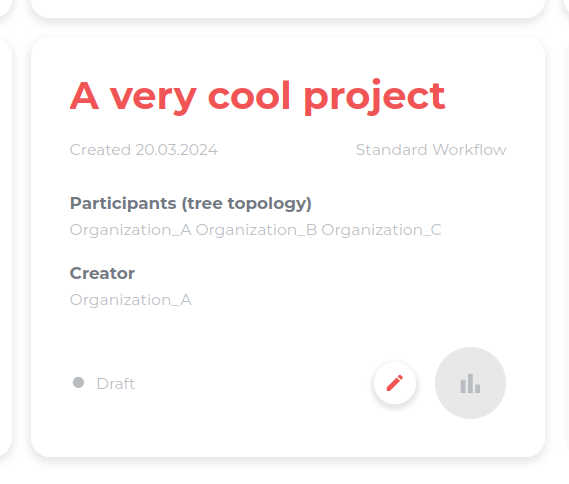

In this tutorial, we will instead focus on what can be achieved with Diapason :-) But feel free to connect to the frontend and see how things change as we update the project.

Now, let's connect our datasource to the project:

In [10]:
project.set_datasource(datasource)

Project objects provide many methods to display various aspects of their status or configuration. For instance, we can check that datasources are connected to the project. Observe that, since we haven't share the project yet, we will only get information about the datasource that we connected.

In [11]:
project.display_datasources()

### Participant:  `Organization_A` (contributor)


#### Table name: `people`


name,age,hair_color,height,weight
TEXT,INT8,TEXT,FLOAT8,FLOAT8


<br>

#### Setting up a datasource query

The mock data is stored in a database. In order to read data from a database, Tune Insight instances require that you define a database query. The query can either be defined directly in the computation, or it can be defined at the project level through a _local data selection_. We will do the latter.


In [12]:
lds = project.get_local_data_selection()
lds.datasource.set_database_query("SELECT * FROM people")

### Setting up project policies

Policies define limitations on what users can do on a project, and can be used to add additional privacy and security requirements in a project. These range from basic features like limiting the allowed computation types to more advanced ones like execution quotas and differential privacy.

Policies are also used to define the _authorization contract_ of a project. Before running a project, users must _authorize_ it. Authorizing a project locks some parts of the computation workflow, as defined by the contract. By default, _all_ parts are locked. In this notebook, we want to be able to run different types of computations, with different parameters and preprocessing, so we will change the contract to be more permissive.

In [13]:
policy = project.get_policy()
policy.set_contract(computation_type=True, computation_parameters=True, preprocessing=True, data_query=True)
project.set_policy(policy)

#### Sharing a project

In order to run collective computations, we need to share the project with other participants.

In [14]:
# project.share()

### Setting up computations

So far, we have only done mostly "administrative" tasks, that can be easily be performed with the frontend. It is when configuring and running computations that Diapason truly shines, unlocking the full power of Tune Insight instances.

With Diapason:
1. you have access to all computations,
1. you can configure _preprocessing_ operations to manipulate the data before the computation,
1. you can run multiple computations in a single project.

To create a computation, you will need to instantiate a `Computation` object of the chosen type on the project. Depending on the specific computation, the object can take additional parameters in its constructor to configure it. All computations implement a `.run` method that returns the results, usually formatted in a useful format (the specific format depends on the computation), and some also implement higher level methods that provide more complex functionality.

#### A very simple computation: dataset length

To begin with, and to illustrate the general concepts, let's begin with the dataset length operation (also called `Count`).

In [15]:
from tuneinsight.computations import DatasetLength

In [16]:
computation = DatasetLength(project)

Before running the project, all participants involved must authorize it. In this notebook, we will only run local computations, so we only need to authorize the project on this instance.

In [17]:
project.request_authorization()

In [18]:
# Note: only DPOs and administrators can authorize a project, so the following line might not work for you.
# For the purposes of this notebook, authorization is not actually required (only local computations), so you can ignore errors in this cell.
project.authorize() 

Let's run the computation and get the result :)

_Note: in this notebook, we will run mostly local computations, since collective computations would require the approval of all other parties in the network. However, as you will see below, running a collective computation is just a matter of setting a flag to `True` -- the rest of the code remains unchanged._

In [19]:
computation.run(local=True)

1000

As expected, we count a thousand records in the data.

Let's do something a bit more interesting: an encrypted aggregation (equivalently called `Sum` in Diapason).

In [20]:
from tuneinsight.computations import Aggregation

This computation performs a sum over numerical data: we must define a subset of columns to use it. A simple way to do this is to define it in the constructor.

In [21]:
computation = Aggregation(project, columns=["weight", "height"])

In [22]:
computation.run(local=True)

,Column,Total
0,weight,77775.21
1,height,125071.56


Let's now use preprocessing to make it more interesting (and showcase what you can do with Diapason). Computations have a `.preprocessing` attribute that allows you to build a preprocessing chain.

Let's use it to compute a histogram of hair color values and of heights (divided in, say, 5 bins).

In [23]:
computation = Aggregation(project)

The `one_hot_encoding` operation creates 1-hot encoded columns. We must specify the list of possible values (`specified_types`) so that the operation works collectively, since the datasets being aggregated need to have consistent columns.

In [24]:
colors = ["black", "brown", "blond", "white", "red"]
computation.preprocessing.one_hot_encoding("hair_color", prefix="hair", specified_types=colors);

Let's compute a histogram of binned heights. For this, we first `cut` the values in one of five bins.

In [25]:
height_bins = ["small", "average", "tall"]

computation.preprocessing.cut("height", "binned_height", cuts=[50, 140, 180, 200], labels=height_bins)
computation.preprocessing.one_hot_encoding("binned_height", prefix="height", specified_types=height_bins)

Let's (arbitrarily) consider only adults.

In [26]:
from tuneinsight import models
computation.preprocessing.filter("age", models.ComparisonType.GREATEREQ, "18", numerical=True);

Next, we use `.select` to specify which columns to use.

In [27]:
computation.preprocessing.select(
    [f"hair_{color}" for color in colors] + 
    [f"height_{h}" for h in height_bins]);

In [28]:
computation.run(local=True)

,Column,Total
0,hair_black,138
1,hair_brown,143
2,hair_blond,140
3,hair_white,143
4,hair_red,140
5,height_small,478
6,height_average,244
7,height_tall,131


#### More advanced computation: group-by aggregation

Computing histograms is a very common data science task, and doing it manually (as above) using preprocessing is time-consuming. To this end, the `Aggregation` can be parameterized to group the values before aggregating.

In [29]:
computation = Aggregation(project,groups=[("height",[50, 80, 120, 150, 180, 200])])
computation.run(local=True)

,height,count
0,"[120,150)",209
1,"[150,180)",192
2,"[180,200)",137
3,"[50,80)",202
4,"[80,120)",260


In [30]:
computation = Aggregation(project,groups=[("hair_color",["brown", "black", "red", "white"])])
computation.run(local=True)

,hair_color,count
0,black,167
1,brown,166
2,red,167
3,white,166


This group by operation can also be followed by computing the average or sum of values in each subgroup. For instance, we can compute the average height and weight for each hair color!

In [31]:
computation = Aggregation(
    project,
    groups=[("hair_color",["brown", "black", "red", "white"])],
    columns=["height","weight","age"],
    average=True
    )
computation.run(local=True)

,hair_color,age,count,height,weight,average_height,average_weight,average_age
0,black,9894,167,19984.64,13097.01,119.67,78.43,59.25
1,brown,10025,166,21345.23,13001.85,128.59,78.32,60.39
2,red,9562,167,20824.13,12778.84,124.70,76.52,57.26
3,white,10231,166,20168.21,12326.25,121.50,74.25,61.63


Or, perharps more usefully: let's see if people get taller as they get older (remember that correlation in the mock data?).

In [32]:
computation = Aggregation(
    project,
    groups=[("age",[20,40,60,80])],
    columns=["height","weight"],
    average=True
    )
computation.run()

,age,count,height,weight,average_height,average_weight
0,"(,20)",164,16359.10,10023.09,99.75,61.12
1,"[20,40)",163,17578.73,10525.46,107.84,64.57
2,"[40,60)",165,19899.11,12696.64,120.60,76.95
3,"[60,80)",168,21845.06,13772.14,130.03,81.98
4,"[80,)",340,49389.56,30757.89,145.26,90.46


### Conclusion

In this notebook, we learned how to use Diapason to set up a simple project, create mock data, and compute statistics over the data. This highlighted a few key features of Diapason:
- Access to advanced computations types, such as `Statistics`,
- Ability to run multiple, dynamically adjusted, computations on a project,
- Preprocessing operations to tailor the project to complex use cases.

But we've barely scratched the surface: there's many more things that can be done with Diapason. Refer to [the documentation](https://dev.tuneinsight.com/docs/Usage/python-sdk/) and other tutorial notebooks for more details.